In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo_resample = Nc.HICosmoDEXcdm()
cosmo_resample.props.H0 = 67.81
cosmo_resample.props.Omegac = 0.3
cosmo_resample.props.Omegab = 0.0486
cosmo_resample.props.Omegax = 1 - 0.0486 - 0.3
cosmo_resample.props.w = -1.3

reion_resample = Nc.HIReionCamb.new()
prim_resample = Nc.HIPrimPowerLaw.new()

cosmo_resample.add_submodel(reion_resample)
cosmo_resample.add_submodel(prim_resample)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim_resample.props.n_SA = 0.9660


prim_resample.props.ln10e10ASA = 3.427449698161606


z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim_resample.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.427449698161606


# Construct the $S_{ij}$  Matrix

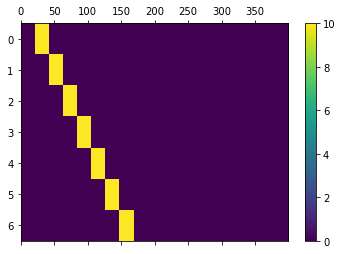

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
cosmo_sij = Nc.HICosmoDEXcdm()
cosmo_sij.props.H0 = 67.81
cosmo_sij.props.Omegac = 0.2612
cosmo_sij.props.Omegab = 0.0486
cosmo_sij.props.Omegax = 1 - 0.0486 - 0.2612
cosmo_sij.props.w = -1.0

reion_sij = Nc.HIReionCamb.new()
prim_sij = Nc.HIPrimPowerLaw.new()

prim_sij.props.ln10e10ASA = 3.027449698161606

cosmo_sij.add_submodel(reion_sij)
cosmo_sij.add_submodel(prim_sij)

# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_sij)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_fit = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_fit.set(i, j, S_lacasa_full[i][j])


S_fit.log_vals("Sij: ", "% 22.15g")

Full sky time (seconds) = 0.9277939796447754
Sij:    1.92205319085382e-05  -3.04726645445555e-06  -6.04545259102587e-07  -2.02354715411165e-07  -9.32160495649247e-08  -4.32106427672728e-08  -1.90803614987959e-08
Sij:   -3.04726645445555e-06   7.12171754166054e-06  -1.30815224272619e-06  -3.43354929148129e-07  -1.20783654717458e-07  -5.56397614613165e-08  -2.82786985378823e-08
Sij:   -6.04545259102587e-07  -1.30815224272619e-06   3.71290086823134e-06   -7.1578051846635e-07  -2.22245005874443e-07  -7.93379826247391e-08  -3.85138450766495e-08
Sij:   -2.02354715411165e-07  -3.43354929148129e-07   -7.1578051846635e-07   2.30455505844292e-06  -4.76124156183105e-07  -1.56884100384222e-07  -5.92862331711515e-08
Sij:   -9.32160495649247e-08  -1.20783654717458e-07  -2.22245005874443e-07  -4.76124156183105e-07   1.59104842325399e-06  -3.31877304663383e-07  -1.21087808042877e-07
Sij:   -4.32106427672728e-08  -5.56397614613165e-08  -7.93379826247391e-08  -1.56884100384222e-07  -3.31877304663383e-07

# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)
cad.prepare(cosmo_resample, cluster_z, cluster_m)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset_resample = Ncm.MSet.new_array([cosmo_resample,cluster_m,cluster_z])
mset_sij = Ncm.MSet.new_array([cosmo_sij,cluster_m,cluster_z])
ser = Ncm.Serialize.new(Ncm.SerializeOpt.NONE)

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
ncounts_gauss.set_has_ssc(True)
rng = Ncm.RNG.seeded_new (None, 42)

# Creating the fit object and calculating the MC

In [9]:
print("MC 3 parameters 1sigma error")

#preparing the resample model

cosmo_resample.props.Omegax = 1 - 0.0486 - 0.27275
cosmo_resample.props.w = -0.91
cosmo_resample.props.Omegac = 0.27275
prim_resample.props.ln10e10ASA = 3.1


S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_resample.set(i, j, S_lacasa_full[i][j])


S_resample.log_vals("Sij_resample: ", "% 22.15g")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_resample_s_matrix(S_resample)
ncounts_gauss.set_s_matrix(S_fit)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_sij.props.Omegac_fit = True
cosmo_sij.props.Omegab_fit = False
cosmo_sij.props.w_fit = True
prim_sij.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_resample))


mset_fit = mset_sij.dup(ser)
mset_fit.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc.set_fiducial(mset_resample)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_3parameters_1sigma.fits")

fitmc.start_run()
fitmc.run(500)
fitmc.end_run()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))

MC 3 parameters 1sigma error
Sij_resample:      1.919436058639e-05  -3.01406683392029e-06  -6.11939410993516e-07  -2.04494427118194e-07  -8.90635516716003e-08  -4.46700291757049e-08  -3.22124923237045e-08
Sij_resample:   -3.01406683392029e-06   7.27340653819302e-06  -1.32936859950149e-06   -3.5119103791367e-07  -1.23141773307614e-07  -5.33095734115734e-08  -3.33149400510397e-08
Sij_resample:   -6.11939410993516e-07  -1.32936859950149e-06   3.81132943303564e-06  -7.32448420831126e-07  -2.32128382325051e-07  -8.19522995617371e-08  -4.22885631346992e-08
Sij_resample:   -2.04494427118194e-07   -3.5119103791367e-07  -7.32448420831126e-07   2.39491037726751e-06  -4.90056923470391e-07  -1.63338071309495e-07  -6.24476430715633e-08
Sij_resample:   -8.90635516716003e-08  -1.23141773307614e-07  -2.32128382325051e-07  -4.90056923470391e-07   1.66676093403548e-06  -3.40285175925383e-07  -1.26354363037976e-07
Sij_resample:   -4.46700291757049e-08  -5.33095734115734e-08  -8.19522995617371e-08  -1.633

In [10]:
print("MC sanity test")

#preparing the resample model

cosmo_resample.props.Omegax = 1 - 0.0486 - 0.8
cosmo_resample.props.w = -0.5
cosmo_resample.props.Omegac = 0.8
prim_resample.props.ln10e10ASA = 4.027

ncounts_gauss.set_s_matrix(S_fit)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_resample.set(i, j, S_lacasa_full[i][j])


ncounts_gauss.set_resample_s_matrix(S_resample)

ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
print("\n")
ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")



guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_sij.props.Omegac_fit = True
cosmo_sij.props.Omegab_fit = False
cosmo_sij.props.w_fit = True
prim_sij.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_resample))


mset_fit = mset_sij.dup(ser)
mset_fit.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc.set_fiducial(mset_resample)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_sanity_resample_fit.fits")

fitmc.start_run()
fitmc.run(500)
fitmc.end_run()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))

ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fit.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)



MC sanity test
y: 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Sij_resample:    2.98126888622304e-05  -3.67400488321855e-06  -8.33506428841902e-07  -1.07539400384503e-07  -7.03393029729369e-08  -3.82617663534728e-08  -6.89462895577224e-09
Sij_resample:   -3.67400488321855e-06   1.22684701998557e-05  -2.09787393606441e-06  -3.22259164447952e-07  -8.84237949082469e-08   -5.7028091292516e-08  -3.40023586143084e-08
Sij_resample:   -8.33506428841902e-07  -2.09787393606441e-06    6.1822581400749e-06  -1.43843361694495e-06  -2.23912315523158e-07  -9.08147107141556e-08  -3.36940948054001e-08
Sij_resample:   -1.07539400384503e-07  -3.22259164447952e-07  -1.43843361694495e-06   3.27595770685233e-06  -9.42422275190228e-07  -1.71985702370561e-07  -6.72301731749075e-08
Sij_resample:   -7.03393029729369e-08  -8.84237949082469e-08  -2.23912315523158e-07  -9.42422275190228e-07   2.44595983285067e-06  -7.14508889800242e-07  -1.43035728716402e-07
Sij_resample:   -3.82617663534728e-08   -5.7028091292516e-08


(process:3372): NUMCOSMO-WARNING **: 16:14:59.191: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


In [11]:
print("MC sanity test")

#preparing the resample model

cosmo_resample.props.Omegax = 1 - 0.0486 - 0.8
cosmo_resample.props.w = -0.5
cosmo_resample.props.Omegac = 0.8
prim_resample.props.ln10e10ASA = 4.027


S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_resample.set(i, j, S_lacasa_full[i][j])




guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)

ncounts_gauss.set_resample_s_matrix(S_resample)
ncounts_gauss.set_s_matrix(S_resample)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
print("\n")
ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_resample.props.Omegac_fit = True
cosmo_resample.props.Omegab_fit = False
cosmo_resample.props.w_fit = True
prim_resample.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_resample))


mset_fit = mset_resample.dup(ser)
mset_fit.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc.set_fiducial(mset_resample)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_sanity_resample_resample.fits")

fitmc.start_run()
fitmc.run(500)
fitmc.end_run()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))

ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fit.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

MC sanity test
y: 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Sij_resample:    2.98126888622304e-05  -3.67400488321855e-06  -8.33506428841902e-07  -1.07539400384503e-07  -7.03393029729369e-08  -3.82617663534728e-08  -6.89462895577224e-09
Sij_resample:   -3.67400488321855e-06   1.22684701998557e-05  -2.09787393606441e-06  -3.22259164447952e-07  -8.84237949082469e-08   -5.7028091292516e-08  -3.40023586143084e-08
Sij_resample:   -8.33506428841902e-07  -2.09787393606441e-06    6.1822581400749e-06  -1.43843361694495e-06  -2.23912315523158e-07  -9.08147107141556e-08  -3.36940948054001e-08
Sij_resample:   -1.07539400384503e-07  -3.22259164447952e-07  -1.43843361694495e-06   3.27595770685233e-06  -9.42422275190228e-07  -1.71985702370561e-07  -6.72301731749075e-08
Sij_resample:   -7.03393029729369e-08  -8.84237949082469e-08  -2.23912315523158e-07  -9.42422275190228e-07   2.44595983285067e-06  -7.14508889800242e-07  -1.43035728716402e-07
Sij_resample:   -3.82617663534728e-08   -5.7028091292516e-08


(process:3372): NUMCOSMO-WARNING **: 16:15:01.444: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


In [12]:
print("MCMC sanity test")

#preparing the resample model

cosmo_resample.props.Omegax = 1 - 0.0486 - 0.8
cosmo_resample.props.w = -0.5
cosmo_resample.props.Omegac = 0.8
prim_resample.props.ln10e10ASA = 4.027

ncounts_gauss.set_s_matrix(S_fit)

S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_resample.set(i, j, S_lacasa_full[i][j])


ncounts_gauss.set_resample_s_matrix(S_resample)

ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
print("\n")
ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")

ncounts_gauss.resample(mset_resample, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_sij.props.Omegac_fit = True
cosmo_sij.props.Omegab_fit = False
cosmo_sij.props.w_fit = True
prim_sij.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_resample))


mset_fit = mset_sij.dup(ser)
mset_fit.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
)


init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_fit)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 120000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_fit.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_sanity_resample_fit.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))

MCMC sanity test
Sij_resample:    2.98126888622304e-05  -3.67400488321855e-06  -8.33506428841902e-07  -1.07539400384503e-07  -7.03393029729369e-08  -3.82617663534728e-08  -6.89462895577224e-09
Sij_resample:   -3.67400488321855e-06   1.22684701998557e-05  -2.09787393606441e-06  -3.22259164447952e-07  -8.84237949082469e-08   -5.7028091292516e-08  -3.40023586143084e-08
Sij_resample:   -8.33506428841902e-07  -2.09787393606441e-06    6.1822581400749e-06  -1.43843361694495e-06  -2.23912315523158e-07  -9.08147107141556e-08  -3.36940948054001e-08
Sij_resample:   -1.07539400384503e-07  -3.22259164447952e-07  -1.43843361694495e-06   3.27595770685233e-06  -9.42422275190228e-07  -1.71985702370561e-07  -6.72301731749075e-08
Sij_resample:   -7.03393029729369e-08  -8.84237949082469e-08  -2.23912315523158e-07  -9.42422275190228e-07   2.44595983285067e-06  -7.14508889800242e-07  -1.43035728716402e-07
Sij_resample:   -3.82617663534728e-08   -5.7028091292516e-08  -9.08147107141556e-08  -1.71985702370561e

In [13]:
print("MCMC sanity test")

#preparing the resample model

cosmo_resample.props.Omegax = 1 - 0.0486 - 0.8
cosmo_resample.props.w = -0.5
cosmo_resample.props.Omegac = 0.8
prim_resample.props.ln10e10ASA = 4.027

S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_resample.set(i, j, S_lacasa_full[i][j])

ncounts_gauss.set_s_matrix(S_resample)
ncounts_gauss.set_resample_s_matrix(S_resample)

ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
print("\n")
ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")

ncounts_gauss.resample(mset_resample, rng)

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo_resample.props.Omegac_fit = True
cosmo_resample.props.Omegab_fit = False
cosmo_resample.props.w_fit = True
prim_resample.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_resample))


mset_fit = mset_resample.dup(ser)
mset_fit.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
)


init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_fit)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 240000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_fit.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_sanity_resample_resample.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()


print("Full sky guaranteed time (seconds) = " + str(t1 - t0))

MCMC sanity test
Sij_resample:    2.98126888622304e-05  -3.67400488321855e-06  -8.33506428841902e-07  -1.07539400384503e-07  -7.03393029729369e-08  -3.82617663534728e-08  -6.89462895577224e-09
Sij_resample:   -3.67400488321855e-06   1.22684701998557e-05  -2.09787393606441e-06  -3.22259164447952e-07  -8.84237949082469e-08   -5.7028091292516e-08  -3.40023586143084e-08
Sij_resample:   -8.33506428841902e-07  -2.09787393606441e-06    6.1822581400749e-06  -1.43843361694495e-06  -2.23912315523158e-07  -9.08147107141556e-08  -3.36940948054001e-08
Sij_resample:   -1.07539400384503e-07  -3.22259164447952e-07  -1.43843361694495e-06   3.27595770685233e-06  -9.42422275190228e-07  -1.71985702370561e-07  -6.72301731749075e-08
Sij_resample:   -7.03393029729369e-08  -8.84237949082469e-08  -2.23912315523158e-07  -9.42422275190228e-07   2.44595983285067e-06  -7.14508889800242e-07  -1.43035728716402e-07
Sij_resample:   -3.82617663534728e-08   -5.7028091292516e-08  -9.08147107141556e-08  -1.71985702370561e